<a href="https://colab.research.google.com/github/francealip/assignment_1_ISPR_23-24/blob/main/src/LoG_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>ASSIGNMENT 7: implementation of blob detector using laplatian of a gaussian<h2>

<h4><b>Author</b>: Aliprandi Francesco<h4>


<h4><b>1. CODE</b></h4>


In [150]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
#from google.colab import drive
#drive.mount('/content/drive')

In [151]:
#Utiliy functions for image processing

def read_images(dir):
    """
    function that read the images in the directory and return a list of images

    :dir: directory path of the images
    :return: list of images
    """
    img = []
    # Loop through each file in the directory
    for filename in os.listdir(dir):
        if filename.endswith(".png"):
            image_path = os.path.join(dir, filename)
            # Open the image and convert to grey scale
            image = Image.open(image_path).convert("L")
            img.append(image)
    return img

def laplacian_of_gaussian(sigma):
    """
    Create the laplacian of a Gaussian filter kernel.

    :parameter sigma: Standard deviation of the Gaussian function.
    :return: LoG filter kernel
    """
    size = np.ceil(6*sigma)
    
    #fix odd size for centering the filter
    if(size%2 == 0):
        size = size + 1
        
    # Create vector of coordinates
    x, y = np.meshgrid(np.arange(-size//2 + 1, size//2 + 1), np.arange(-size//2 + 1, size//2 + 1))
    
    # Compute normalized laplacian of a Gaussian function using the coordinates
    log = ((-1/(np.pi * sigma**2))*(1-((x*x+y*y)/(2*sigma**2)))*np.exp(-(x*x+y*y)/(2*sigma**2)))

    return log

def filter_size(filter):
    """
    function that returns the size of the filter

    :param filter: filter
    :return: size of the filter
    """
    return filter.shape[0]

def convolution(img, filter):
    """
    function that performs convolution on the image with LoG filter

    :param img: image to be convoluted
    :param filter: filter to convolve
    :return: convoluted image
    """
    img = np.array(img)

    conv_dim = tuple(x - y + 1 for x, y in zip(img.shape, filter.shape))
    img_conv = np.zeros(conv_dim)
    #print(img_conv.shape)
    for i in range(conv_dim[0]):
        for j in range(conv_dim[1]):
            img_conv[i, j] = np.sum(img[i:i+filter.shape[0], j:j+filter.shape[1]]*filter)
    
    return img_conv


def thresholding(img):
    """
    function that performs thresholding on the image

    :param img: image to be thresholded
    :return: thresholded image
    """
    img = np.array(img) 
    threshold =  np.average(img)
    img[img < threshold] = 0
    return img


def multiple_scale_execution(img, sigma_zero):
    """
    function that performs LoG filter convolution and thresholding on the image for multiple scales

    :param img: image to be processed
    :param scales: list of scales
    :return: list of processed images
    """
    k = 2
    img = np.array(img)
    img_list = []
    for i in range(0, 5):
        sigma = sigma_zero*(k**i)
        log_filter = laplacian_of_gaussian(sigma)
        img_conv = convolution(img, log_filter)
        img_list.append(thresholding(img_conv))
    return img_list



In [152]:
#support function for plotting

def plot_image(image,i,sigma):
    """
    function that plots the images in the list

    :param images: list of images
    :param i: index of the image
    :param sigma: standard deviation of the filter
    """
    plt.imshow(image, cmap='gray')
    plt.title('Immagine'+str(i)+"_sigma_"+ str(sigma))
    plt.axis('off')  # Disabilita gli assi
    plt.show()

    (plt.gcf())

def bid_plot(LoG_filter):
    """
    plot of the LoG filter in 2D space

    :parameter LoG_filter: LoG filter kernel
    """

    # Plot the LoG filter as an image
    plt.imshow(LoG_filter, cmap='gray')
    plt.title('2D - Laplacian of Gaussian Filter')
    plt.colorbar(label='Filter Value')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

def tridim_plot(LoG_filter,sigma):
    """
    plot of the LoG filter in 3D space

    :parameter LoG_filter: LoG filter kernel
    """
    size = np.ceil(6*sigma)

    # Create vector of coordinates
    x = np.arange(-size//2 , size//2 + 1)
    y = np.arange(-size//2 , size//2 + 1)
    x, y = np.meshgrid(x, y)
    z = LoG_filter

    # Plot 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, cmap='viridis')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Filter Value')
    ax.set_title('3D Plot of Laplacian of Gaussian Filter')

    plt.show()
    
        
    def draw_circle(image, coordinates):
        """
        plot blob detectors on the specified image
        
        :parameter image: image to be plotted
        :parameter coordinates: list of coordinatets with respectives radius stored as y,x,3
        """
    
        _, ax = plt.subplots()
        image = np.array(image)

        ax.imshow(image, interpolation='nearest',cmap="gray")
        for blob in coordinates:
            y,x,r = blob
            c = plt.Circle((x, y), r*1.414, color='red', linewidth=1, fill=False)
            ax.add_patch(c)
        ax.plot()  
        plt.show()


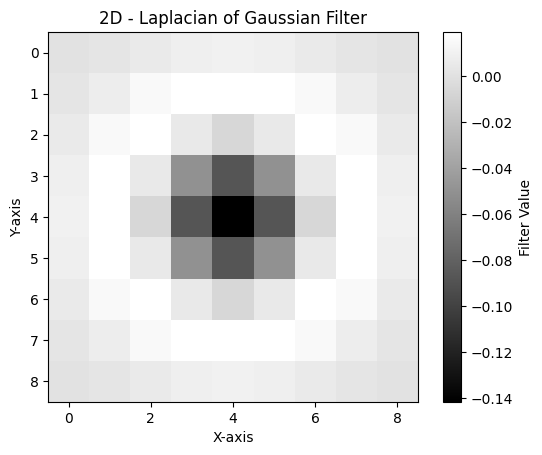

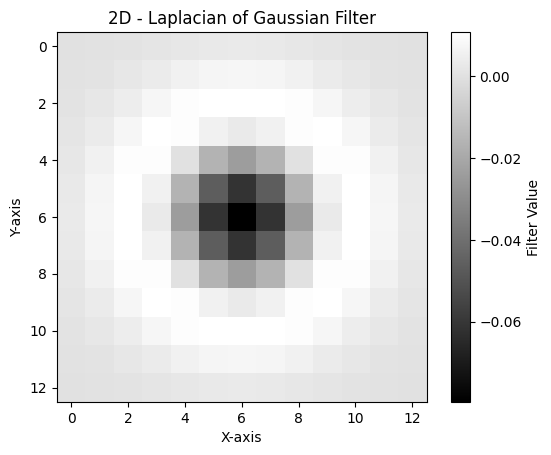

In [153]:
bid_plot(laplacian_of_gaussian(1.5))
bid_plot(laplacian_of_gaussian(2))

<h4>2. TEST</h4>

In [154]:
#get images directory

current_dir = os. getcwd()
parent_dir = os.path.dirname(current_dir)
img_dir = os.path.join(parent_dir, "images")

#colab
#img_dir  = os.getcwd() + "/drive/MyDrive/ispr/assignment1"

#read test images
img1, img2, img3 = read_images(img_dir)

#img2.show()

<h4>2.1 Test su immagine 1</h4>

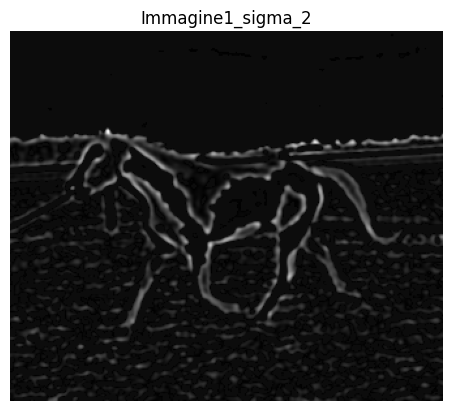

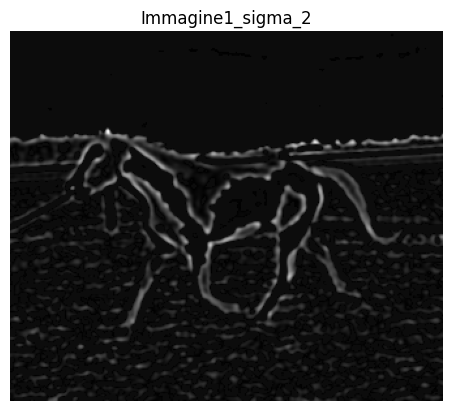

<Figure size 640x480 with 0 Axes>

In [155]:
import cv2
import numpy as np

sigma = 2
img = img2
# Apply Gaussian blur with sigma 
blurred = cv2.GaussianBlur(np.array(img), (0, 0), sigma)

# Apply Laplacian of Gaussian (LoG) filter
result1 = cv2.Laplacian(blurred, cv2.CV_64F)
result1 = np.uint8(np.absolute(result1))

def LoG(sigma):
    #window size 
    n = np.ceil(sigma*6)
    y,x = np.ogrid[-n//2:n//2+1,-n//2:n//2+1]
    y_filter = np.exp(-(y*y/(2.*sigma*sigma)))
    x_filter = np.exp(-(x*x/(2.*sigma*sigma)))
    final_filter = (-(2*sigma**2) + (x*x + y*y) ) *  (x_filter*y_filter) * (1/(2*np.pi*sigma**4))
    return final_filter


filter = laplacian_of_gaussian(sigma)
result2 = thresholding(convolution(img, filter))
filter = laplacian_of_gaussian(sigma)
result = thresholding(convolution(img, filter))

#plot_image(img1,2,0)

plot_image(result2,1,sigma)
plot_image(result,1,sigma)

# Imposta le opzioni di stampa per visualizzare l'intero array senza limitazioni
np.set_printoptions(threshold=np.inf)

#print(convolution(img, filter)[0])
#print(result1[0])
#print(result)

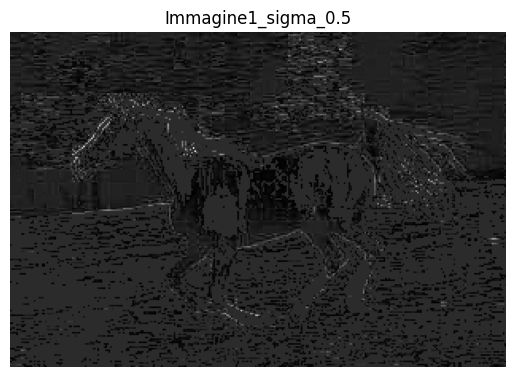

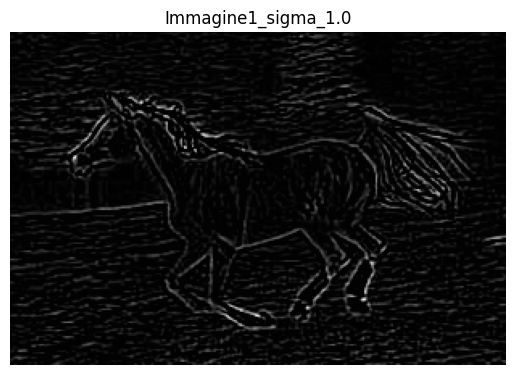

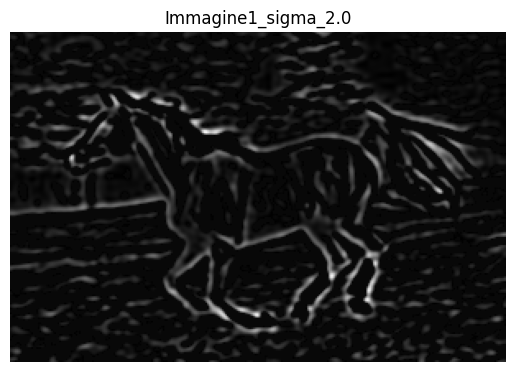

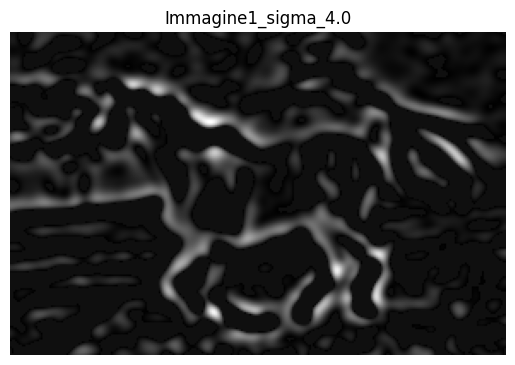

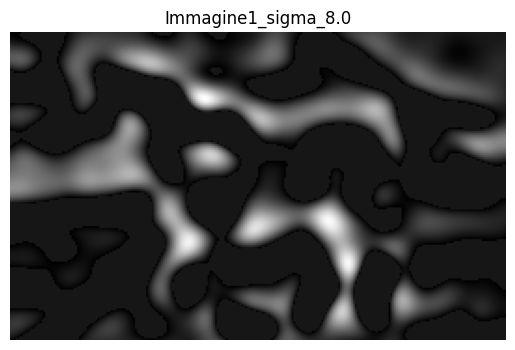

<Figure size 640x480 with 0 Axes>

In [156]:
feature_maps = multiple_scale_execution(img1, 0.5)

for i,img in enumerate(feature_maps):
    sigma =0.5 * 2**i
    plot_image(img,1,sigma)
    


